# 7.4 Практическая работа

Научиться применять предобученные эмбеддинги для решения NLP-задач с помощью BERT и GPT-2.

План ноутбука:.

1. Вводные по задаче.

2. Библиотеки.

3. Блок функций.

4. Загрузка и подготовка данных.

5. Определение архитектуры нейросети.

6. Модель BERT

7. Модель GPT-2

8. Результаты и выводы.

## Вводные по задаче.

Что нужно сделать

Вы научитесь предсказывать наличие спама в сообщениях из электронной почты на основе содержащегося в них текста. Используя один из способов получения векторов, достигните минимального значения метрики F1-score — 0,8.

Выполните задание с использованием PyTorch.

Датасет: Emails for spam or ham classification (Trec 2006).

Файл: email_text.csv.

    1 .Установите !pip install sentence_transformers.
    
    2. Загрузите файл email_text.csv из датасета Emails for spam or ham classification (Trec 2006), используйте для работы первую тысячу строк.
    Проверьте на наличие null-значений и удалите их, если они есть.
    
    3. Проведите предобработку текста: преобразуйте текст в нижний регистр; преобразуйте сокращения; удалите лишние пробелы, знаки препинания, стоп-слова; лемматизируйте слова.
    
    4. Загрузите предобученную модель.
    
    5. Разделите полученные данные на тестовую и обучающую выборки в соотношении 80 на 20.
    
    6. Преобразуйте X_train, X_test, y_train, y_test в тензоры PyTorch.
    
    7. Создайте DataLoader для обучающего и тестового наборов данных, используя TensorDataset и DataLoader.
    
    8. Постройте архитектуру простой нейронной сети для решения задачи бинарной классификации.
    
    9. Оцените работу модели, построив графики Accuracy и Loss.
    
    10. Рассчитайте для тестовой выборки метрики Accuracy, F1-score.
    
    11. Сравните методы получения эмбеддингов. Какой результат лучше и почему?

Критерии оценки

Принято: загружен датасет, выполнена предобработка текста, получены векторы, обучена модель, оценена работа модели, получены указанные метрики.

На доработку: не выполнен один из критериев.

Ожидаемые метрики для BERT:

    F1-score — 0,85.
    Accuracy — 0,75.

Ожидаемые метрики для GPT-2:

    F1-score — 0,84.
    Accuracy — 0,73.

## Библиотеки.

In [35]:
#pip install sentence_transformers
# !pip install nltk

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
from tqdm import tqdm
import pickle
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer # предобученые модели
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model # предобученые модели
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import StepLR
import gc # сборщик мусора

# Загрузка необходимых ресурсов NLTK
#nltk.download('punkt') изменилось название nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt_tab')

In [37]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Предобработка данных
# Загрузка необходимых ресурсов NLTK
#nltk.download('punkt') изменилось название nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/leostuchchi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
import nltk.data

try:
    nltk.data.find('tokenizers/punkt')
    print("Resource punkt found.")
except LookupError:
    print("Resource punkt not found.")

Resource punkt found.



from_pretrained: Этот метод загружает предобученную модель и соответствующий токенизатор из репозитория Hugging Face.

Токенизация: Текст преобразуется в формат, который может быть обработан моделью (тензоры).

Выходные данные:
    
    Для BERT вы получаете выходные данные, содержащие представления входных данных.
    
    Для GPT-2 вы можете использовать метод generate для генерации текста.


## Блок функций.

In [4]:
def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text




# Функция для получения эмбеддингов из GPT-2
def get_gpt2_embeddings(texts):
    # Токенизация текстов
    tokens = tokenizer_gpt(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model_gpt(**tokens)
    # Получение эмбеддингов (используем последний скрытый слой)
    return outputs.last_hidden_state.mean(dim=1)  # Среднее по всем токенам


def training(model, epochs, optimizer, criterion, train_loader, test_loader):
    '''
    input: model, epochs, optimizer, criterion, train_loader, test_loader
    output: model, train_losses, test_losses, train_accuracies, test_accuracies
    '''

    # Пустые списки для хранения значений потерь и точности на обучающей и тестовой выборках
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Обучение модели
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            # Убедитесь, что outputs имеет размерность [N]
            outputs = outputs.view(-1)  # Меняем размерность на [N]

            loss = criterion(outputs, labels.float())  # Вычисление потерь
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Вычисление точности на обучающей выборке
            predicted_train = (outputs >= 0.5).float()  # бинаризация выходов
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        # Сохранение значений потерь и точности на обучающей выборке
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Оценка модели на тестовой выборке
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)

                # Убедитесь, что outputs имеет размерность [N]
                outputs = outputs.view(-1)  # Меняем размерность на [N]

                loss = criterion(outputs, labels.float())
                test_loss += loss.item()

                # Вычисление точности на тестовой выборке
                predicted_test = (outputs >= 0.5).float()  # бинаризация выходов
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()

        # Сохранение значений потерь и точности на тестовой выборке
        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct_test / total_test)

        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

    return model, train_losses, test_losses, train_accuracies, test_accuracies



def plots(train_losses, test_losses, train_accuracies, test_accuracies):
    # Построение графиков
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), train_losses, label='Training Loss')
    plt.plot(range(1, 11), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracies')
    plt.legend()

    plt.tight_layout()
    plt.show()



def metrix(model, test_loader):
    # Оценка модели на тестовой выборке
    model.eval()
    y_pred_list = []
    y_true_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            predicted_labels = (outputs > 0.5).long()

            y_pred_list.extend(predicted_labels.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())

    # Расчет метрик для тестовой выборки
    accuracy_test = accuracy_score(y_true_list, y_pred_list)
    f1_score_test = f1_score(y_true_list, y_pred_list)

    print(f'Test Accuracy: {accuracy_test:.4f}')
    print(f'Test F1 Score: {f1_score_test:.4f}')


## Загрузка и подготовка данных

In [ ]:
# используйте для работы первую тысячу строк.
#full_data_path = "data/email_text.csv"
full_data_path = "/content/drive/MyDrive/Scientist/Advanced/NLP/data/email_text.csv"
df = pd.read_csv(full_data_path, usecols=lambda column: column != 'id', nrows=1000)

In [6]:
df.head()

,label,text
0,0,the mailing list i queried about a few weeks a...
1,1,luxury watches buy your own rolex for only esc...
2,1,academic qualifications available from prestig...
3,0,greetings all this is to verify your subscript...
4,1,try chauncey may conferred the luscious not co...


In [7]:
df.shape

(1000, 2)

### Баланс классов

In [47]:
df['label'].value_counts()

label
0    652
1    348
Name: count, dtype: int64

In [8]:
# Проверяем на наличие null-значений
df.isnull().sum()

label    0
text     0
dtype: int64

In [9]:
print(df.shape)
#df.dropna(inplace=True)
df.shape

(1000, 2)


(1000, 2)

In [10]:
# нормализация текста
df['text'] = df['text'].map(lambda i : text_cleaner(i))
df.head()

,label,text
0,0,mailing list queried week ago running also set...
1,1,luxury watch buy rolex escapenumber rolex cart...
2,1,academic qualification available prestigious n...
3,0,greeting verify subscription planescapenumber ...
4,1,try chauncey may conferred luscious continued ...


In [15]:
# Извлечение текстовых данных и меток классов
X = df['text'].tolist()  # Извлекаем текстовые данные в список строк
y = df['label'].tolist()  # Извлекаем метки классов в список

In [16]:
# Проверка на наличие пустых значений или неправильных типов данных (опционально)
X = [text for text in X if isinstance(text, str) and len(text) > 0]
y = [label for label in y if label in [0, 1]]  # Предполагается, что метки бинарные (0 или 1)

In [17]:
# проверка данных
print(len(df))
print(len(X))
print(len(y))

1000
1000
1000


## Определение архитектуры нейросети.

### Применим одну и ту-же архитектуру простой нейросети для чистоты эксперимента.

In [ ]:
# Определение архитектуры нейронной сети для бинарной классификации
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Выходной слой с размером 1 для бинарной классификации
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


SimpleNN — это полносвязная нейронная сеть (feedforward neural network), которая может быть использована для задач классификации. 

Входные данные:

Входные данные для модели должны быть правильно подготовлены. Для BERT и GPT-2 вам нужно будет извлекать эмбеддинги или выходы из этих моделей и передавать их в SimpleNN.

Обработка выходов:

Выходы BERT и GPT-2 имеют разные форматы:

BERT: Обычно выходы из [CLS] токена для задач классификации.

GPT-2: Использовать последний токен или усреднить эмбеддинги по всем токенам.

## Модель BERT

In [53]:
# разделение train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Загрузка токенизатора и модели BERT
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

# Если использовать SentenceTransformer
sentence_model_bert = SentenceTransformer('bert-base-uncased')

No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.


### Преобразование с помощью sentence_model_bert = SentenceTransformer('bert-base-nli-mean-tokens')

In [55]:
# модель не найдена!
# No sentence-transformers model found with name bert-base-uncased. Creating a new one with mean pooling.
# !! изменил название модели
sentence_model_bert = SentenceTransformer('bert-base-nli-mean-tokens')

In [56]:
# Преобразуем текстовые данные в векторы эмбеддингов
bert_embeddings_train = sentence_model_bert.encode(X_train, convert_to_tensor=True).to(device)
bert_embeddings_test = sentence_model_bert.encode(X_test, convert_to_tensor=True).to(device)

Если метки являются бинарными, то использование float32 для меток может быть не обязательно. Если метки — это целые числа, можно оставить их в формате float32, но обычно для классификации используются целые числа (dtype=torch.long)

dtype=torch.long для меток, если классы в виде целых чисел. Если метки — это бинарные значения (0 и 1), то использование dtype=torch.float32 может быть оправдано, особенно если вы используете функцию потерь, такую как BCEWithLogitsLoss.

In [57]:
# Преобразование меток в тензоры PyTorch
#y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Преобразование меток в тензоры PyTorch
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [58]:
# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(bert_embeddings_train, y_train_tensor)
test_dataset = TensorDataset(bert_embeddings_test, y_test_tensor)

train_loader_b = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_b = DataLoader(test_dataset, batch_size=32)



In [60]:
# Параметры модели
input_size = bert_embeddings_train.size(1)  # Размер эмбеддинга (например, 768 для BERT)
hidden_size = 128  # Размер скрытого слоя

In [61]:
# Инициализация модели, функции потерь и оптимизатора
model_b = SimpleNN(input_size=input_size, hidden_size=hidden_size)
criterion = nn.BCELoss()  # Функция потерь для бинарной классификации
optimizer = optim.Adam(model_b.parameters(), lr=0.001)

In [62]:
model_b.to(device)
criterion = criterion.to(device)
epochs = 10

In [63]:
# Обучение модели
model_b, train_losses_b, test_losses_b, train_accuracies_b, test_accuracies_b = training(model_b, epochs, optimizer, criterion, train_loader_b, test_loader_b)

Epoch 1, Train Loss: 0.4144072359800339, Train Accuracy: 0.805, Test Loss: 0.2008529773780278, Test Accuracy: 0.945
Epoch 2, Train Loss: 0.211528939306736, Train Accuracy: 0.925, Test Loss: 0.13738477655819484, Test Accuracy: 0.965
Epoch 3, Train Loss: 0.16972523629665376, Train Accuracy: 0.94125, Test Loss: 0.12218605194772993, Test Accuracy: 0.965
Epoch 4, Train Loss: 0.14520655140280725, Train Accuracy: 0.9425, Test Loss: 0.10870886806930814, Test Accuracy: 0.97
Epoch 5, Train Loss: 0.11522806107997895, Train Accuracy: 0.96125, Test Loss: 0.09855108867798533, Test Accuracy: 0.97
Epoch 6, Train Loss: 0.08989122360944748, Train Accuracy: 0.97125, Test Loss: 0.11773850183401789, Test Accuracy: 0.97
Epoch 7, Train Loss: 0.0686321223527193, Train Accuracy: 0.98375, Test Loss: 0.10919208931071418, Test Accuracy: 0.975
Epoch 8, Train Loss: 0.05712105438113212, Train Accuracy: 0.985, Test Loss: 0.10024324165923255, Test Accuracy: 0.97
Epoch 9, Train Loss: 0.045648541450500485, Train Accurac

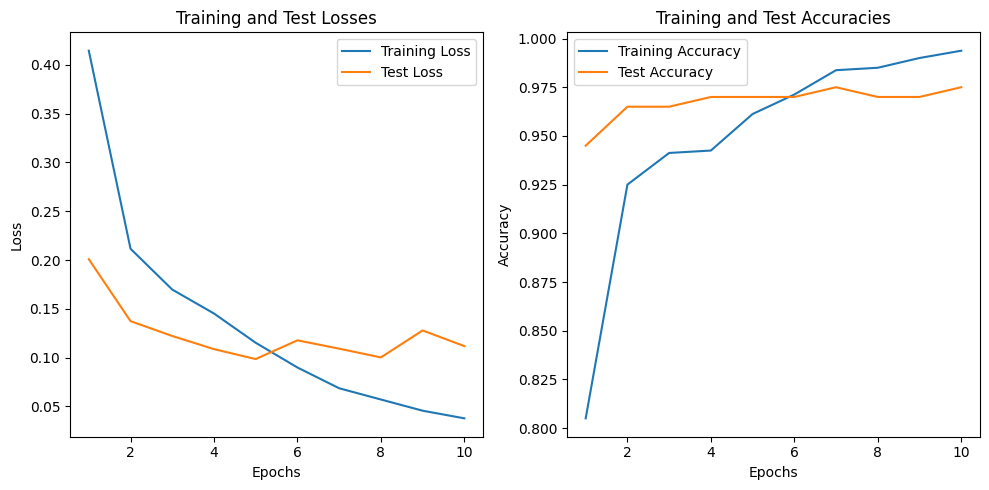

In [64]:
plots(train_losses_b, test_losses_b, train_accuracies_b, test_accuracies_b)

In [65]:
metrix(model_b, test_loader_b)

Test Accuracy: 0.9750
Test F1 Score: 0.9580


## Модель GPT-2

In [66]:
# Загрузка токенизатора и модели
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
model_gpt = GPT2Model.from_pretrained('gpt2')

model_gpt.to(device)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [67]:
# Tokenize и pad sequences
encoded_captions = tokenizer_gpt(X,
    return_tensors='pt',
    padding=True,
    truncation=True)

In [68]:
encoded_captions = {key: value.to(device) for key, value in encoded_captions.items()}

In [69]:
input_ids = encoded_captions['input_ids']

In [ ]:
batch_size = 16

# Инициализируем список для хранения embeddings
all_sentence_embeddings = []

# Разделим данные на батчи и передадим их в модель
for i in range(0, len(encoded_captions['input_ids']), batch_size):
    batch_input_ids = encoded_captions['input_ids'][i:i+batch_size].to(device)
    batch_attention_mask = encoded_captions['attention_mask'][i:i+batch_size].to(device)

    # Передаем батчи в модель
    with torch.no_grad():
        batch_outputs = model_gpt(batch_input_ids)

    # Извлекаем embeddings для каждого батча
    word_embeddings = batch_outputs.last_hidden_state

    # Mask для игнорирования padding tokens
    masked_word_embeddings = word_embeddings * batch_attention_mask.unsqueeze(-1).float()

    # Объединение сумм с учётом токенов без non-padding
    sentence_embeddings = masked_word_embeddings.sum(dim=1)

    # Нормализация по количеству токенов без non-padding
    sentence_embeddings /= batch_attention_mask.sum(dim=1, keepdim=True).float()

    # Добавляем embeddings батча в список
    all_sentence_embeddings.append(sentence_embeddings)

# Собираем все embeddings батчей в один список
all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_sentence_embeddings, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразование данных в тензоры PyTorch перенос на device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

<ipython-input-97-4c6dcbaa68ff>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
<ipython-input-97-4c6dcbaa68ff>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


In [ ]:
# Параметры модели
input_size = 768 #gpt_embeddings_train.size(1)  # Размер эмбеддинга (например, 768 для GPT-2)
print(input_size)
hidden_size = 128  # Размер скрытого слоя

# Инициализация модели, функции потерь и оптимизатора
model_g2 = SimpleNN(input_size=input_size, hidden_size=hidden_size)
# Перемещение модели на устройство
model_g2.to(device)
epochs = 10
criterion = nn.BCELoss()  # Функция потерь для бинарной классификации
optimizer = optim.Adam(model_g2.parameters(), lr=0.001)

768


In [ ]:
# Обучение модели
model_g2, train_losses_g, test_losses_g, train_accuracies_g, test_accuracies_g = training(model_g2, epochs, optimizer, criterion, train_loader, test_loader)

Epoch 1, Train Loss: 0.5633227860927582, Train Accuracy: 0.6925, Test Loss: 0.37889143398829866, Test Accuracy: 0.92
Epoch 2, Train Loss: 0.37172247767448424, Train Accuracy: 0.87, Test Loss: 0.24534493684768677, Test Accuracy: 0.92
Epoch 3, Train Loss: 0.28052856266498566, Train Accuracy: 0.91375, Test Loss: 0.1833087078162602, Test Accuracy: 0.955
Epoch 4, Train Loss: 0.23507775217294694, Train Accuracy: 0.92125, Test Loss: 0.17807471645729883, Test Accuracy: 0.96
Epoch 5, Train Loss: 0.19254545331001283, Train Accuracy: 0.935, Test Loss: 0.11003801226615906, Test Accuracy: 0.97
Epoch 6, Train Loss: 0.16194744259119034, Train Accuracy: 0.9525, Test Loss: 0.10614807584456035, Test Accuracy: 0.96
Epoch 7, Train Loss: 0.14867613479495048, Train Accuracy: 0.95125, Test Loss: 0.09375802001782826, Test Accuracy: 0.96
Epoch 8, Train Loss: 0.13715550392866135, Train Accuracy: 0.9525, Test Loss: 0.08177579487008708, Test Accuracy: 0.975
Epoch 9, Train Loss: 0.11754770204424858, Train Accuracy

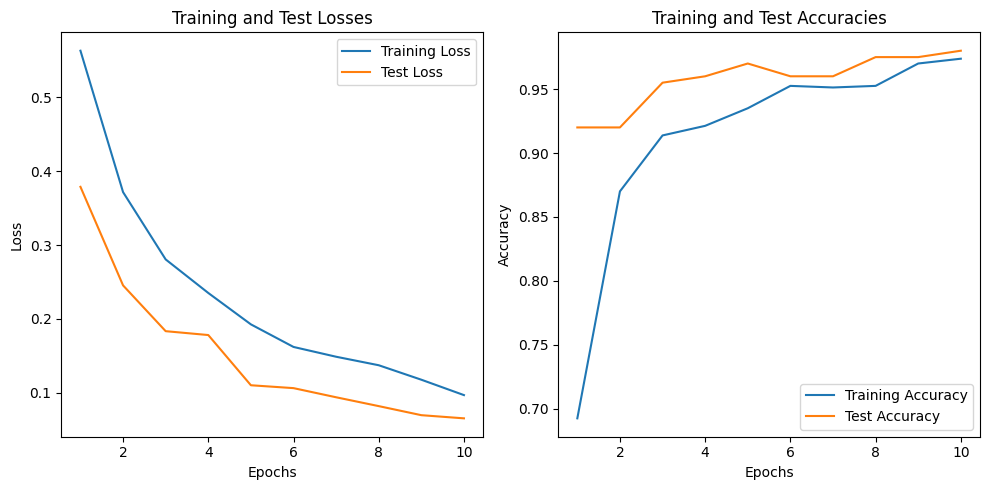

In [ ]:
plots(train_losses_g, test_losses_g, train_accuracies_g, test_accuracies_g)

In [ ]:
metrix(model_g2, test_loader)

Test Accuracy: 0.9800
Test F1 Score: 0.9672


## Результаты и выводы.

Сравнительный анализ предобученных моделей BERT и GPT-2 в контексте задачи бинарной классификации. 

Этапы работы с BERT

    Подготовка данных:
        Данные должны быть нормализованы и подготовлены для токенизации. Для BERT используется специальная разметка с токенами [CLS] и [SEP].
    Токенизация:
        Используется токенизатор BERT для преобразования текста в токены, добавления специальных токенов и создания маски внимания. 
    Создание эмбеддингов:
        Проход через модель BERT для получения эмбеддингов. Для бинарной классификации обычно используется выход [CLS] токена.
    Обучение нейросети:
        Создание простой нейросети для классификации на основе полученных эмбеддингов.
    Оценка производительности:
        Использование метрик точности и потерь для оценки производительности модели на тестовых данных.

Этапы работы с GPT-2

    Подготовка данных:
        Данные также должны быть нормализованы, но без специальной разметки, как в случае с BERT.
    Токенизация:
        Используется токенизатор GPT-2 для преобразования текста в токены.
    Создание эмбеддингов:
        Проход через модель GPT-2 для получения эмбеддингов. Обычно используется последний токен или усреднение по всем токенам.
    Обучение нейросети:
        Аналогично BERT, создается простая нейросеть для классификации на основе полученных эмбеддингов.
    Оценка производительности.


Сложность процессов

    BERT:
        Процесс включает в себя использование маскированного языка для предобучения и требует более сложной подготовки данных (например, добавление специальных токенов).
    GPT-2:
        Процесс проще в плане подготовки данных, так как не требует маскирования и может работать с обычным текстом.


Производительность и ресурсозатратность

    BERT:
        Обычно показывает высокую точность в задачах классификации благодаря двунаправленному обучению.
        Требует значительных ресурсов для обработки длинных последовательностей из-за своей архитектуры.
    GPT-2:
        Хорошо подходит для генерации текста и может показывать хорошие результаты в задачах классификации при правильной настройке.
        Может быть менее эффективным в задачах классификации по сравнению с BERT из-за одностороннего подхода.


Отличия в выходных данных

    BERT:
        Выходные данные представляют собой эмбеддинг [CLS], который агрегирует информацию о всей последовательности.
    GPT-2:
        Выходные данные могут быть представлены как эмбеддинги последнего токена или усредненные эмбеддинги всех токенов.


## Сравнеие полученых метрик обученых нейросетей на основе предобученых моделей BERT и GPT-2

In [ ]:
print('metrix Model BERT')
metrix(model_b, test_loader_b)
print('*'*10)
print('metrix Model GPT-2')
metrix(model_g2, test_loader)

metrix Model BERT
Test Accuracy: 0.9850
Test F1 Score: 0.9752
metrix Model GPT-2
Test Accuracy: 0.9800
Test F1 Score: 0.9672


В целом мы можем видеть сравнительно похожие метрики для обеих моделей. 

Данные метрики получены на десяти эпохах обучения.

Обучение моделей происходило очень быстро.

Однако подготовка эмбендингов, в обоих случаях была более продолжительной.

## Резюме.

Обе модели имеют свои сильные и слабые стороны в контексте задачи бинарной классификации. Выбор между BERT и GPT-2 должен основываться на конкретных требованиях задачи и доступных ресурсах. BERT лучше подходит для задач понимания текста и классификации, тогда как GPT-2 может быть более универсальным инструментом для генерации текста.